# Prova di Analisi 1

In [42]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path

In [44]:
dirName = '../mesons-master/build/dat/'
name = 'odd_prova26.odd_df2_4fop'
datName = name + '.dat'

fileName = dirName + datName

In [45]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

## Lettura da file

In [46]:
noperators=5

output=0

#read binary dat file
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte
    header_size= 6*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf = struct.unpack("iiiiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
        k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

    #these array will be stored in a dict having as keys the configurations
    conf_dict = {}

    #list with configurations number
    conf_num_list = []

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent), conf_len):

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        print(f"Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                        
                            #reading of re and im part of correlators   (...complex numbers)
                            

                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))

                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            #conf_dict[str(conf_number)] = (conn_corr,disc_corr)
            conf_dict[str(conf_number)] = np.asarray( [conn_corr.copy(),disc_corr.copy()] )
        else:
            #conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr,disc_corr)
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = np.asarray([conn_corr.copy(),disc_corr.copy()])
                    

Gauge Conf = 1

Gauge Conf = 2

Gauge Conf = 3



In [47]:
#correctness check:
print( np.shape(conf_dict["1"]) )
#output should be
#2 ncorr nop tvals nnoise nnoise (the 2 is for connected and disconnected

(2, 2, 5, 16, 20, 20)


In [48]:
#conversion dictionaries
noise_dict={0:"Z2",1:"Gauss",2:"U1",3:"One Component"}
dirac_dict={0:"G0",1:"G1",2:"G2",3:"G3",5:"G5",6:"ONE",7:"G0G1",8:"G0G2",9:"G0G3",10:"G0G5",11:"G1G2",12:"G1G3",13:"G1G5",14:"G2G3",15:"G2G5",16:"G3G5"}

latex_dirac_dict={0:r'$\gamma_0$',1:r'$\gamma_1$',2:r'$\gamma_2$',3:r'$\gamma_3$',5:r'$\gamma_5$',6:"1",7:r'$\gamma_0\gamma_1$',8:r'$\gamma_0\gamma_2$',
                  9:r'$\gamma_0\gamma_3$',10:r'$\gamma_0\gamma_5$',11:r'$\gamma_1\gamma_2$',12:r'$\gamma_1\gamma_3$',13:r'$\gamma_1\gamma_5$',
                  14:r'$\gamma_2\gamma_3$',15:r'$\gamma_2\gamma_5$',16:r'$\gamma_3\gamma_5$'}

In [49]:
#Header print
print("[File Header]\n")
print(f"- ncorr           = {ncorr}\n")
print(f"- nnoise          = {nnoise}\n")
print(f"- tvals           = {tvals}\n")
print(f"- noise_type      = {noise_dict[noise_type]}\n")
print(f"- check_gauge_inv = {check_gauge_inv}")

[File Header]

- ncorr           = 2

- nnoise          = 20

- tvals           = 16

- noise_type      = Gauss

- check_gauge_inv = 0


In [50]:
#Correlators Header print
for i in range(ncorr):
    print(f"[Correlator {i}]\n")
    print(f" - k1 = {k1[i]}\n")
    print(f" - k2 = {k2[i]}\n")
    print(f" - k3 = {k3[i]}\n")
    print(f" - k4 = {k4[i]}\n\n")
    print(f" - mu1 = {mu1[i]}\n")
    print(f" - mu2 = {mu2[i]}\n")
    print(f" - mu3 = {mu3[i]}\n")
    print(f" - mu4 = {mu4[i]}\n\n")
    print(f" - typeA = {dirac_dict[typeA[i]]}\n")
    print(f" - typeB = {dirac_dict[typeB[i]]}\n\n")
    print(f" - x0 = {x0[i]}\n")
    print(f" - z0 = {z0[i]}\n\n\n")

[Correlator 0]

 - k1 = 0.121951219512195

 - k2 = 0.12

 - k3 = 0.121951219512195

 - k4 = 0.12


 - mu1 = 0.0

 - mu2 = 0.0

 - mu3 = 0.0

 - mu4 = 0.0


 - typeA = G5

 - typeB = G5


 - x0 = 1

 - z0 = 14



[Correlator 1]

 - k1 = 0.121951219512195

 - k2 = 0.12

 - k3 = 0.12

 - k4 = 0.121951219512195


 - mu1 = 0.0

 - mu2 = 0.0

 - mu3 = 0.0

 - mu4 = 0.0


 - typeA = G0G5

 - typeB = G0G5


 - x0 = 1

 - z0 = 14





In [10]:
conf_dict.keys()

dict_keys(['1', '1_GaugeInvCheck', '2', '2_GaugeInvCheck'])

In [11]:
conf_dict['1'][0][0][0][:][0][0]#conf - piece - corr -op -t -noisA - noiseB

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

In [12]:
#conn_corr = conf_dict['1'][0][0][iop]
#conn_corr[:,0,0]

## Plot Correlatori

In [14]:
print("Available configurations:")
print(list(conf_dict.keys()))
print("\nFor each configuration, available:\n")
print(" - 5 different correlators for 5 different operators (VA,AV,SP,PS,TT~)\n")
print(" - connected and disconnected piece\n")
print(" - nnoise squared G(t) over the time extent of the lattice")

Available configurations:
['1', '2', '3']

For each configuration, available:

 - 5 different correlators for 5 different operators (VA,AV,SP,PS,TT~)

 - connected and disconnected piece

 - nnoise squared G(t) over the time extent of the lattice


For each available configuration we have:  
- 5 different correlators for 5 different operators (VA,AV,SP,PS,TT~)
- connected and disconnected piece
- nnoise squared G(t) over the time extent of the lattice

The structure of the dictionary is:
> conf_dict[conf_id] = (connected_correlator, disconnected_correlator)

The structure of a correlator is 
> correlator = correlator[correlator_id][operator_id][time][noiseB][noiseA]

(16, 20, 20)

array([ 0.00000000e+00+0.00000000e+00j,  2.48685710e-05+4.23412846e-05j,
       -1.90199841e-06-5.57169279e-06j,  3.17137926e-07-3.71478629e-06j,
        6.93628473e-07-2.04644406e-06j,  6.72117282e-07-1.09071648e-06j,
        5.20507917e-07-5.64697814e-07j,  3.38167458e-07-2.62444677e-07j,
        1.30725932e-07-6.10233949e-08j, -1.89120870e-07+1.24287689e-07j,
       -8.94730134e-07+3.76066373e-07j, -2.81039263e-06+7.98524931e-07j,
       -8.63093266e-06+1.45696089e-06j, -2.80604119e-05+1.64954227e-06j,
        2.62667628e-05-5.84527622e-05j,  0.00000000e+00+0.00000000e+00j])

array([0.00000000e+00, 4.91042789e-05, 5.88738978e-06, 3.72829903e-06,
       2.16079933e-06, 1.28117293e-06, 7.67992261e-07, 4.28058919e-07,
       1.44267543e-07, 2.26305397e-07, 9.70550323e-07, 2.92163461e-06,
       8.75304140e-06, 2.81088546e-05, 6.40832914e-05, 0.00000000e+00])

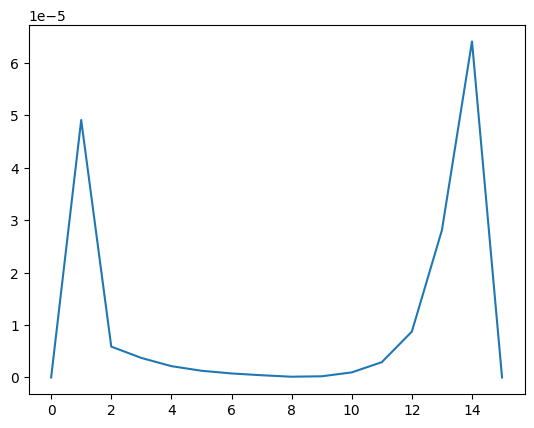

In [15]:
#let's first pick one configuration, one correlator and do everything
#let's first do it for just one operator
#                      first conf - connected piece - correlator0 - operator VA
chosen_corr = conf_dict['1'][0][0][0]
np.shape(chosen_corr)

#average over noiseA and then over noiseB
chosen_corr = chosen_corr.mean(axis=-1).mean(axis=-1)
chosen_corr

#take array of modulus from array of complex number
modulus = np.abs(chosen_corr)
modulus

#plot
times=np.arange(0,tvals)
plt.plot(times,modulus)

Text(0.5, 0, 'Time [lattice units]')

Text(0.5, 1.0, 'VA')

Text(0, 0.5, 'G(t)')

Text(0.5, 1.0, 'AV')

Text(0, 0.5, 'G(t)')

Text(0.5, 1.0, 'SP')

Text(0, 0.5, 'G(t)')

Text(0.5, 1.0, 'PS')

Text(0, 0.5, 'G(t)')

Text(0.5, 1.0, 'T $\\mathbf{\\~{T}}$')

Text(0, 0.5, 'G(t)')

Text(0.5, 0.98, '|G(t)| for parity odd operators - (Configuration 1, Correlator 0)')

Text(1.01, 0.95, 'Correlator 0 parameters:\n           \n$k_1$=0.121951220 \n$k_2$=0.120000000 \n$k_3$=0.121951220 \n$k_4$=0.120000000 \n           \n$\\mu_1$=0.000000000 \n$\\mu_2$=0.000000000 \n$\\mu_3$=0.000000000 \n$\\mu_4$=0.000000000 \n           \n$\\Gamma_A$=$\\gamma_5$\n$\\Gamma_B$=$\\gamma_5$\n           \n$x_0$=1\n$z_0$=14\n           \n           \n           \n           \nSimulation parameters:\n           \n$N_{NOISE}$=20\nNoise Type=Gauss\n$T$=16')

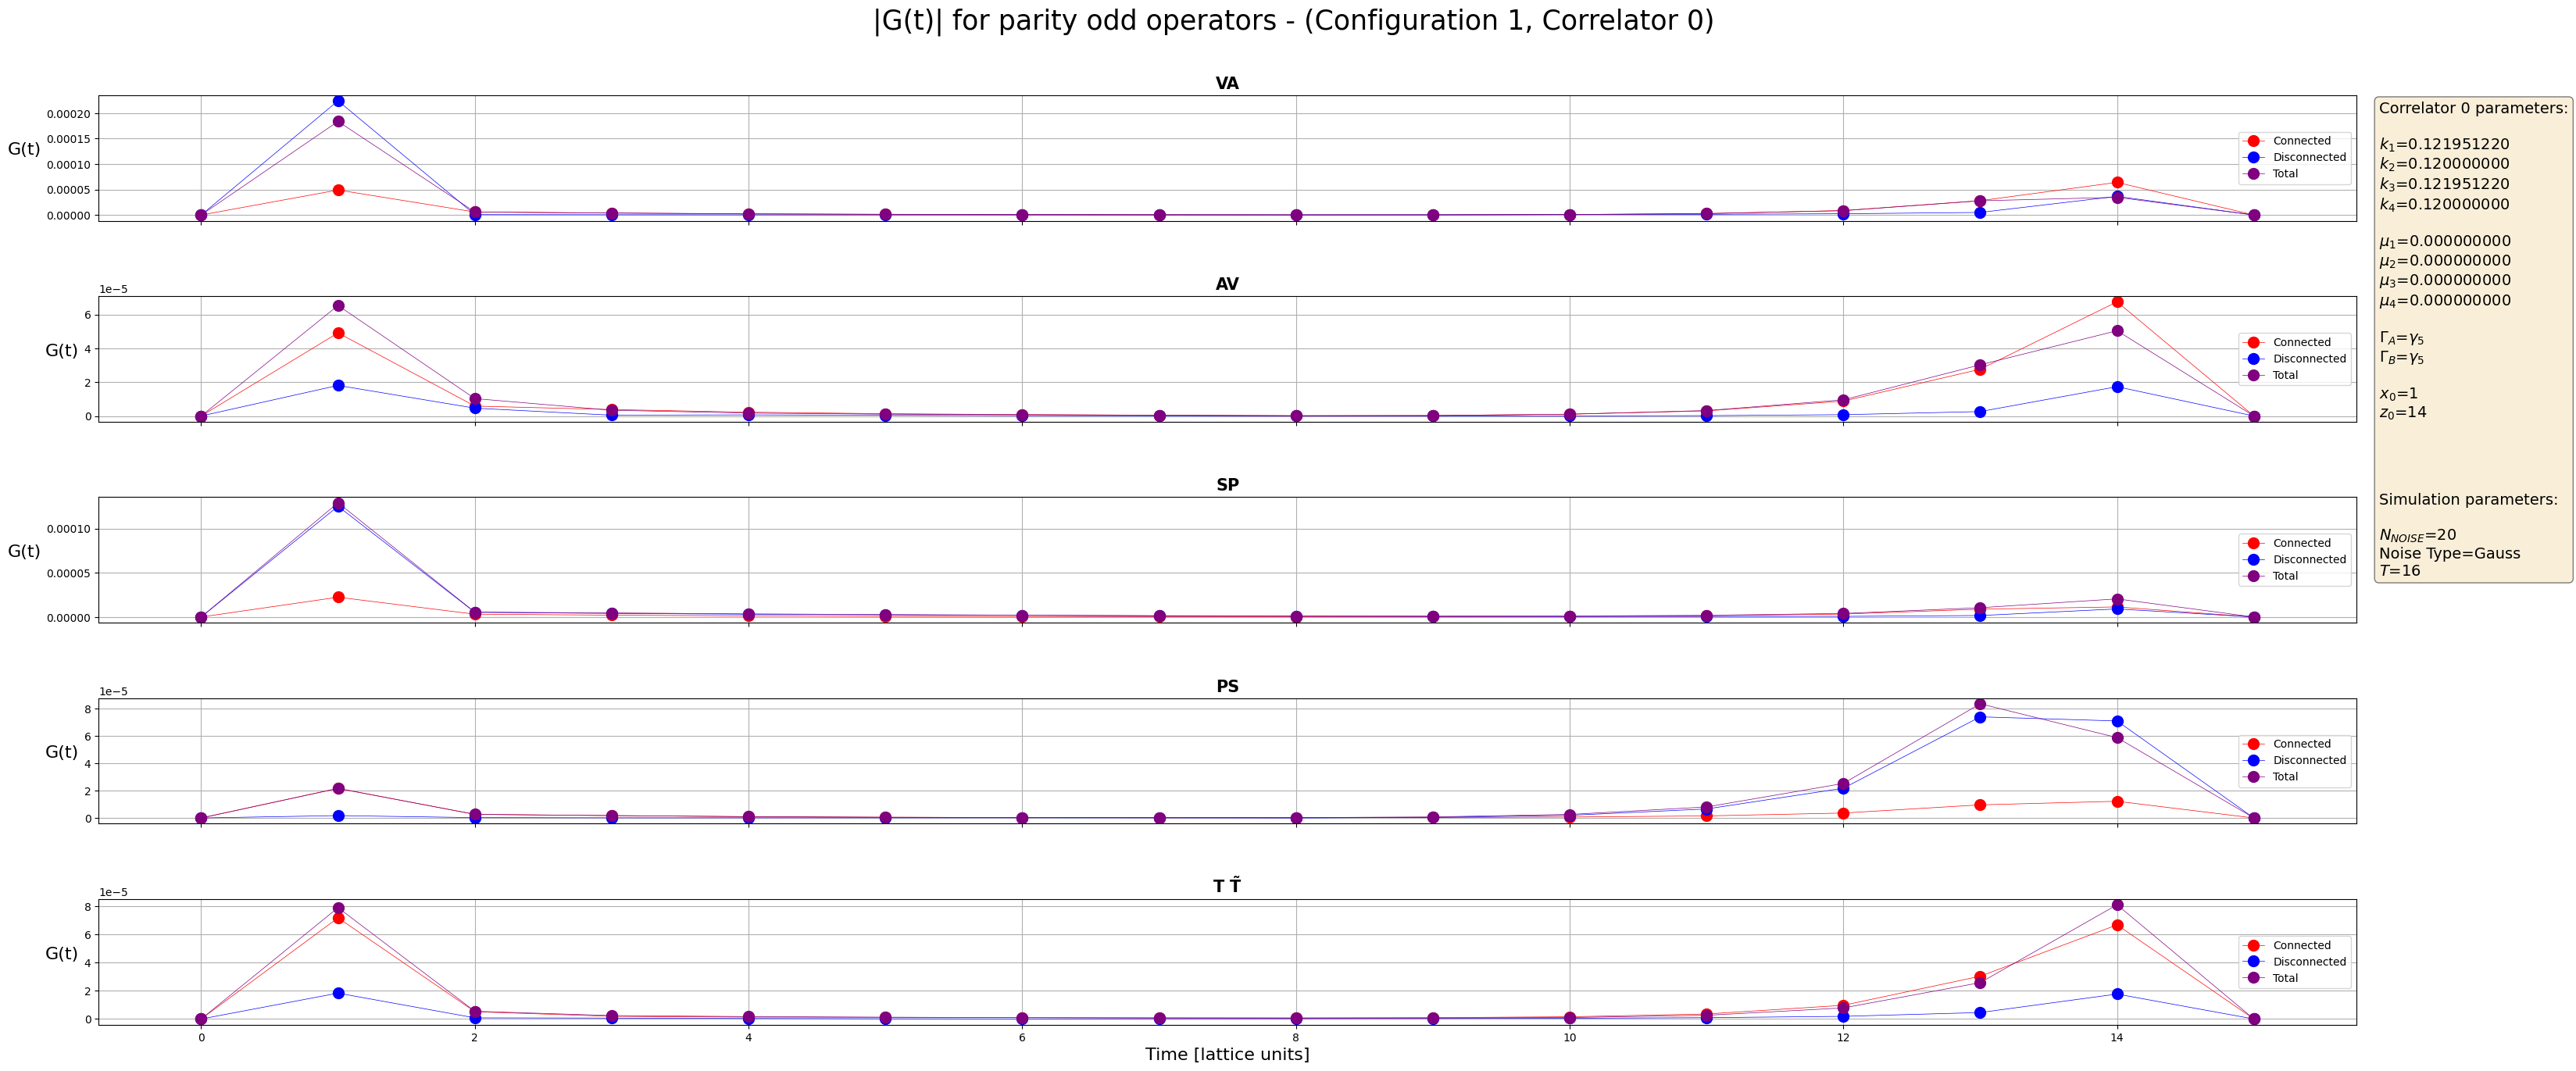

In [16]:
#now led's do the plot with 5 operators

InteractiveShell.ast_node_interactivity = "last_expr"

#names of 5 operators
op_names = ["VA","AV","SP","PS",r'T $\mathbf{\~{T}}$']

#colors = ['red','blue','green','yellow','violet']


#times on x axis
times = np.arange(0,tvals)

fig, ax_list = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=False, figsize=(34, 14))

#fig.set_size_inches(18.5, 10.5, forward=True)


plt.xlabel('Time [lattice units]',fontsize=16)
#plt.ylabel('G(t)',fontsize=16)

for iop,op_name in enumerate(op_names):
    #sp=plt.subplot(5,1,iop+1)

    conn_corr = conf_dict['1'][0][0][iop] #conf 1 - corr 0
    disc_corr = conf_dict['1'][1][0][iop] #conf1 - corr 0
    tot_corr = conn_corr+disc_corr

    corr_list = [conn_corr,disc_corr,tot_corr]
    corr_lab = ["Connected","Disconnected","Total"]
    corr_colors = ["red","blue","purple"]

    

    #take average over noise
    avg_list = [corr.mean(axis=-1).mean(axis=-1) for corr in corr_list]
    #take modulus
    Gt_list = [np.abs(avg) for avg in avg_list]

    for ipiece,Gt in enumerate(Gt_list):
        ax_list[iop].plot(times,Gt,'-o',label=corr_lab[ipiece],color=corr_colors[ipiece],markersize=10,linewidth=0.5)
    
    ax_list[iop].grid()

    ax_list[iop].set_title(op_name,fontsize=15,weight="bold")
    
    ax_list[iop].set_ylabel("G(t)",rotation=0,labelpad=20,fontsize=16)

    ax_list[iop].legend(loc='right')
    
#plt.xticks(times)

plt.subplots_adjust(left=0.05,
                    bottom=0.05, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

#fig.supylabel("G(t)",rotation=0,fontsize=20)
plt.suptitle('|G(t)| for parity odd operators - (Configuration 1, Correlator 0)', fontsize=25,y=0.98,)

#Display text box with frelevant parameters outside the plot
textstr = '\n'.join((
     'Correlator %d parameters:' % (0),
     '           ',
    r'$k_1$=%.9f ' % (k1[0] ),
    r'$k_2$=%.9f ' % (k2[0] ),
    r'$k_3$=%.9f ' % (k3[0] ),
    r'$k_4$=%.9f ' % (k4[0] ),
     '           ',
    r'$\mu_1$=%.9f ' % (mu1[0] ),
    r'$\mu_2$=%.9f ' % (mu2[0] ),
    r'$\mu_3$=%.9f ' % (mu3[0] ),
    r'$\mu_4$=%.9f ' % (mu4[0] ),
     '           ',
    r'$\Gamma_A$=' + latex_dirac_dict[typeA[0]],
    r'$\Gamma_B$=' + latex_dirac_dict[typeB[0]],
     '           ',
    r'$x_0$=%d' % x0[0],
    r'$z_0$=%d' % z0[0],
     '           ',
     '           ',
     '           ',
     '           ',
     'Simulation parameters:',
     '           ',
    r'$N_{NOISE}$=%d' % nnoise,
     'Noise Type=%s' % noise_dict[noise_type],
    r'$T$=%d' % tvals))


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place the text box in upper left in axes coords
plt.text(1.01, 0.95, textstr, transform=ax_list[0].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

#plt.tight_layout()

plt.savefig("prova1.png")

plt.show()

## routine for configuration plotting

In [17]:
def plotCorr(confNumb,corrNumb,runName,save=True,show=False):
    
    #names of 5 operators
    op_names = ["VA","AV","SP","PS",r'T $\mathbf{\~{T}}$']

    #name of dir for plots
    plot_base_dir = "plots/"
    plot_dir=plot_base_dir+'plot_'+name.split('.')[0]
    Path(plot_dir).mkdir(parents=True, exist_ok=True)


    #times on x axis
    times = np.arange(0,tvals)

    #create figure and axis
    fig, ax_list = plt.subplots(nrows=5, ncols=1, sharex=True, sharey=False, figsize=(32, 14))



    #loop over plot, one for each of the 5 operators
    for iop,op_name in enumerate(op_names):

        #compute connected, disconnected and total operatpr
        conn_corr = conf_dict[confNumb][0][corrNumb][iop] #conf - piece - corr - op
        disc_corr = conf_dict[confNumb][1][corrNumb][iop] 
        tot_corr = conn_corr+disc_corr

        #array for connected,disconnected,total correaltors
        corr_list = [conn_corr,disc_corr,tot_corr]
        corr_lab = ["Connected","Disconnected","Total"]
        corr_colors = ["red","blue","purple"]

    

        #take average over noise
        avg_list = [corr.mean(axis=-1).mean(axis=-1) for corr in corr_list]
        #take modulus
        Gt_list = [np.abs(avg) for avg in avg_list]

        #plot 3 pieces
        for ipiece,Gt in enumerate(Gt_list):
            ax_list[iop].plot(times,Gt,'-o',label=corr_lab[ipiece],color=corr_colors[ipiece],markersize=10,linewidth=0.5)

        #enable grid
        ax_list[iop].grid()

        #set title
        ax_list[iop].set_title(op_name,fontsize=15,weight="bold")

        #set y label
        ax_list[iop].set_ylabel("G(t)",rotation=0,labelpad=20,fontsize=16)

        #set legend
        ax_list[iop].legend(loc='right')

    
    #set x ticks to be all time values
    #plt.xticks(times)

    #adjust subplot spacing
    plt.subplots_adjust(left=0.04,
                        bottom=0.05, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.6)

    #set x label
    #fig.supylabel("G(t)",rotation=0,fontsize=20)
    plt.xlabel('Time [lattice units]',fontsize=16)

    #set title
    plt.suptitle(f'|G(t)| for parity odd operators - (Configuration {confNumb}, Correlator {corrNumb})', fontsize=25,y=0.98,)

    #Display text box with frelevant parameters outside the plot
    textstr = '\n'.join((
         'Correlator %d parameters:' % (corrNumb),
         '           ',
        r'$k_1$=%.9f ' % (k1[corrNumb] ),
        r'$k_2$=%.9f ' % (k2[corrNumb] ),
        r'$k_3$=%.9f ' % (k3[corrNumb] ),
        r'$k_4$=%.9f ' % (k4[corrNumb] ),
         '           ',
        r'$\mu_1$=%.9f ' % (mu1[corrNumb] ),
        r'$\mu_2$=%.9f ' % (mu2[corrNumb] ),
        r'$\mu_3$=%.9f ' % (mu3[corrNumb] ),
        r'$\mu_4$=%.9f ' % (mu4[corrNumb] ),
         '           ',
        r'$\Gamma_A$=' + latex_dirac_dict[typeA[corrNumb]],
        r'$\Gamma_B$=' + latex_dirac_dict[typeB[corrNumb]],
         '           ',
        r'$x_0$=%d' % x0[corrNumb],
        r'$z_0$=%d' % z0[corrNumb],
         '           ',
         '           ',
         '           ',
         '           ',
         'Simulation parameters:',
         '           ',
        r'$N_{NOISE}$=%d' % nnoise,
         'Noise Type=%s' % noise_dict[noise_type],
        r'$T$=%d' % tvals))


    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place the text box in upper left in axes coords
    plt.text(1.01, 0.95, textstr, transform=ax_list[0].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    #save figure
    if save:
        fig_name = f"prova_conf{confNumb}_corr{corrNumb}_{runName}.png"
        plt.savefig(plot_dir+"/"+fig_name)

    #show figure
    if show:
        plt.show()

## all plots

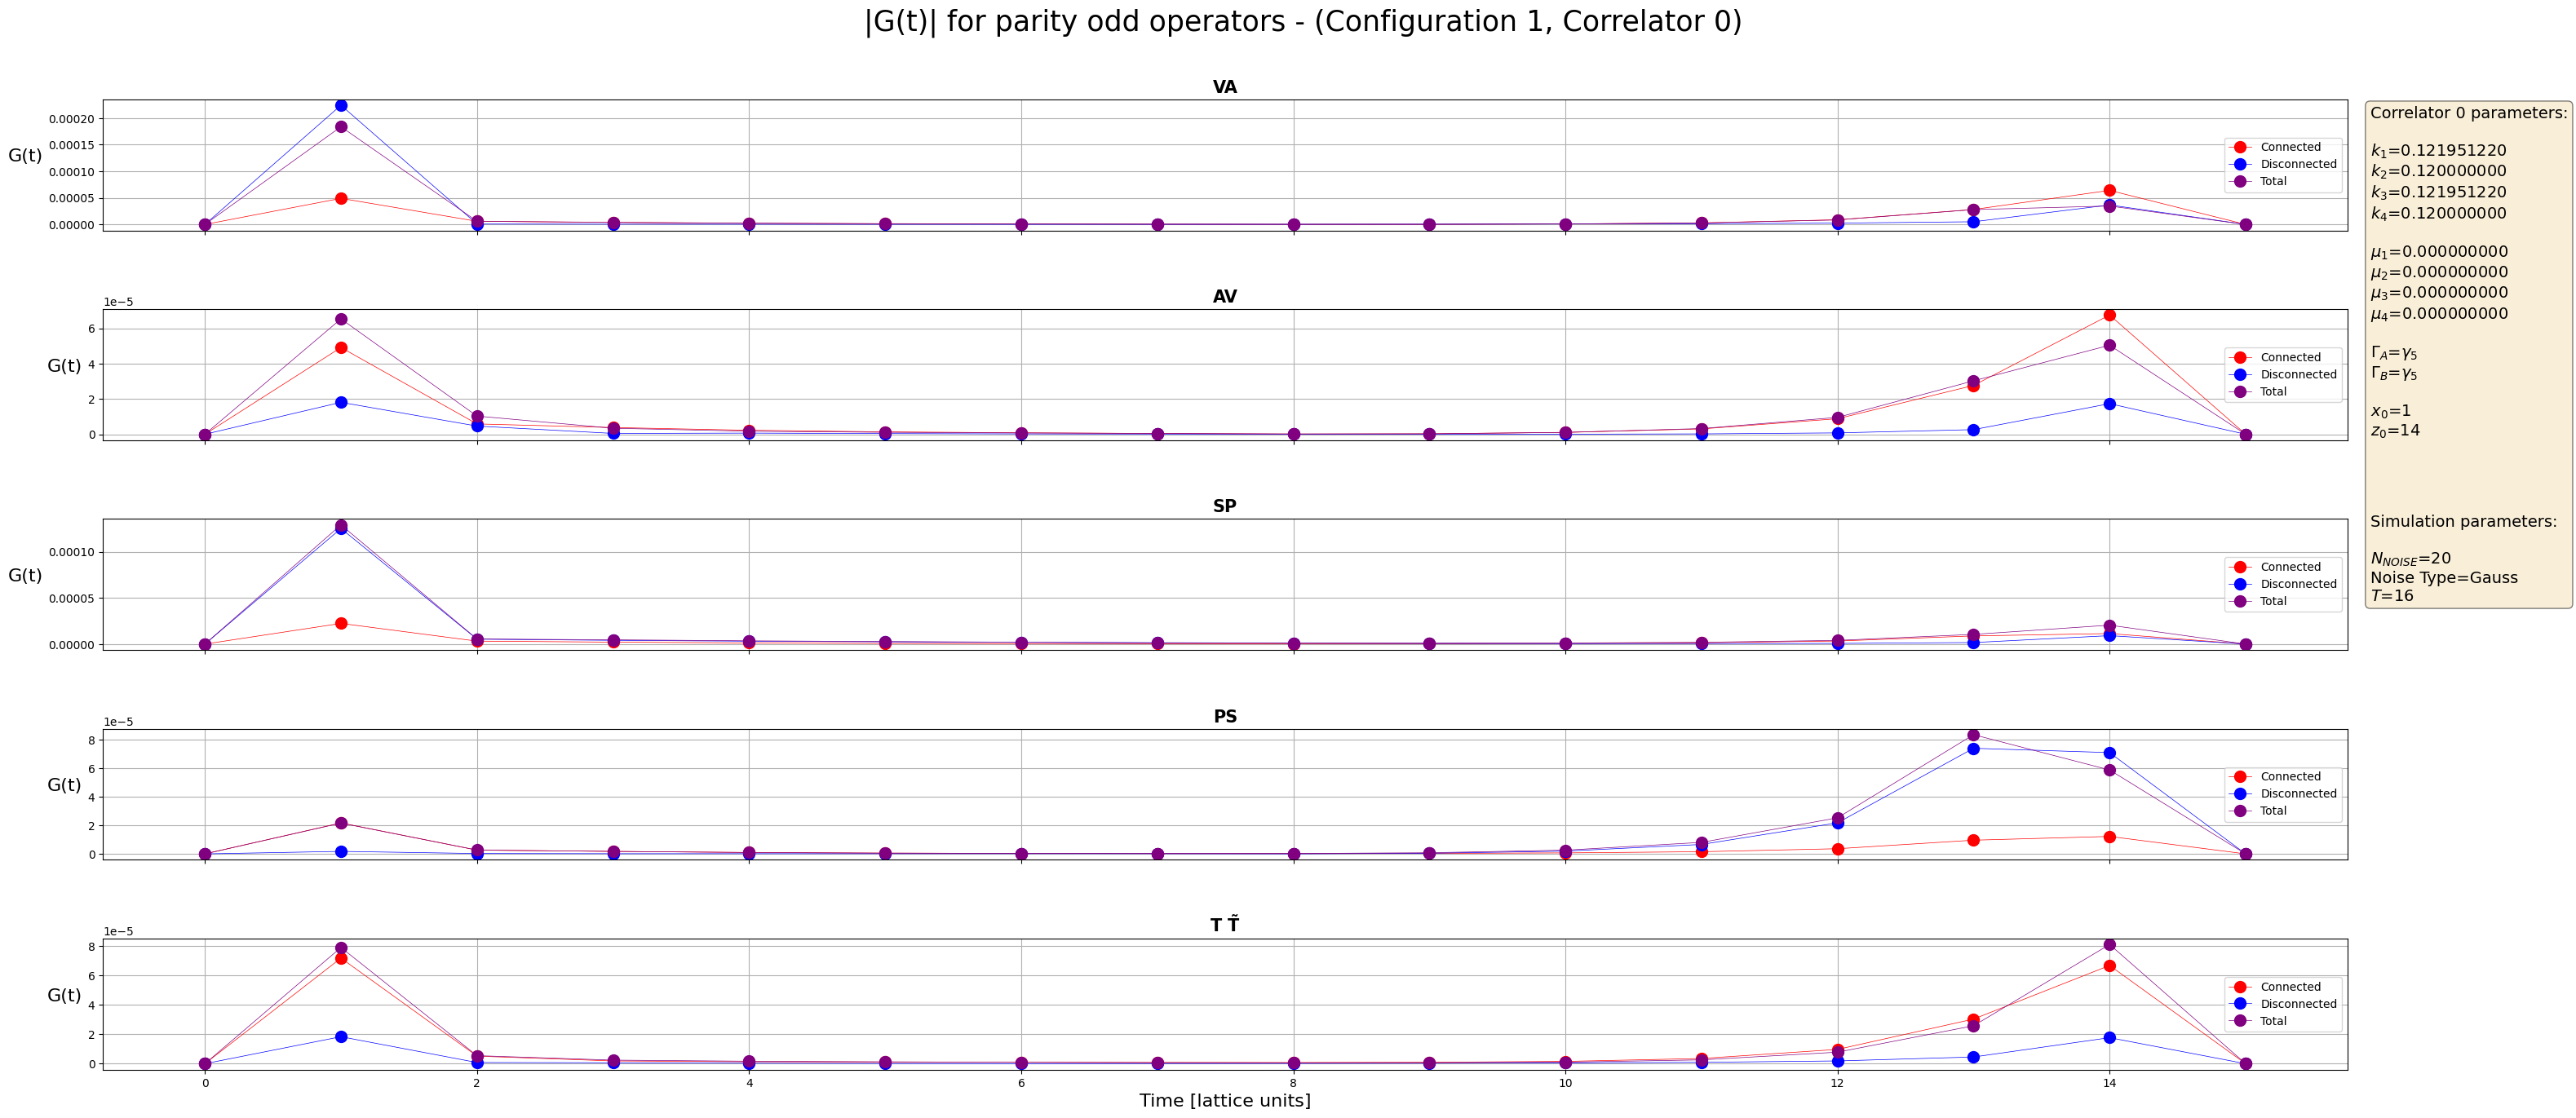

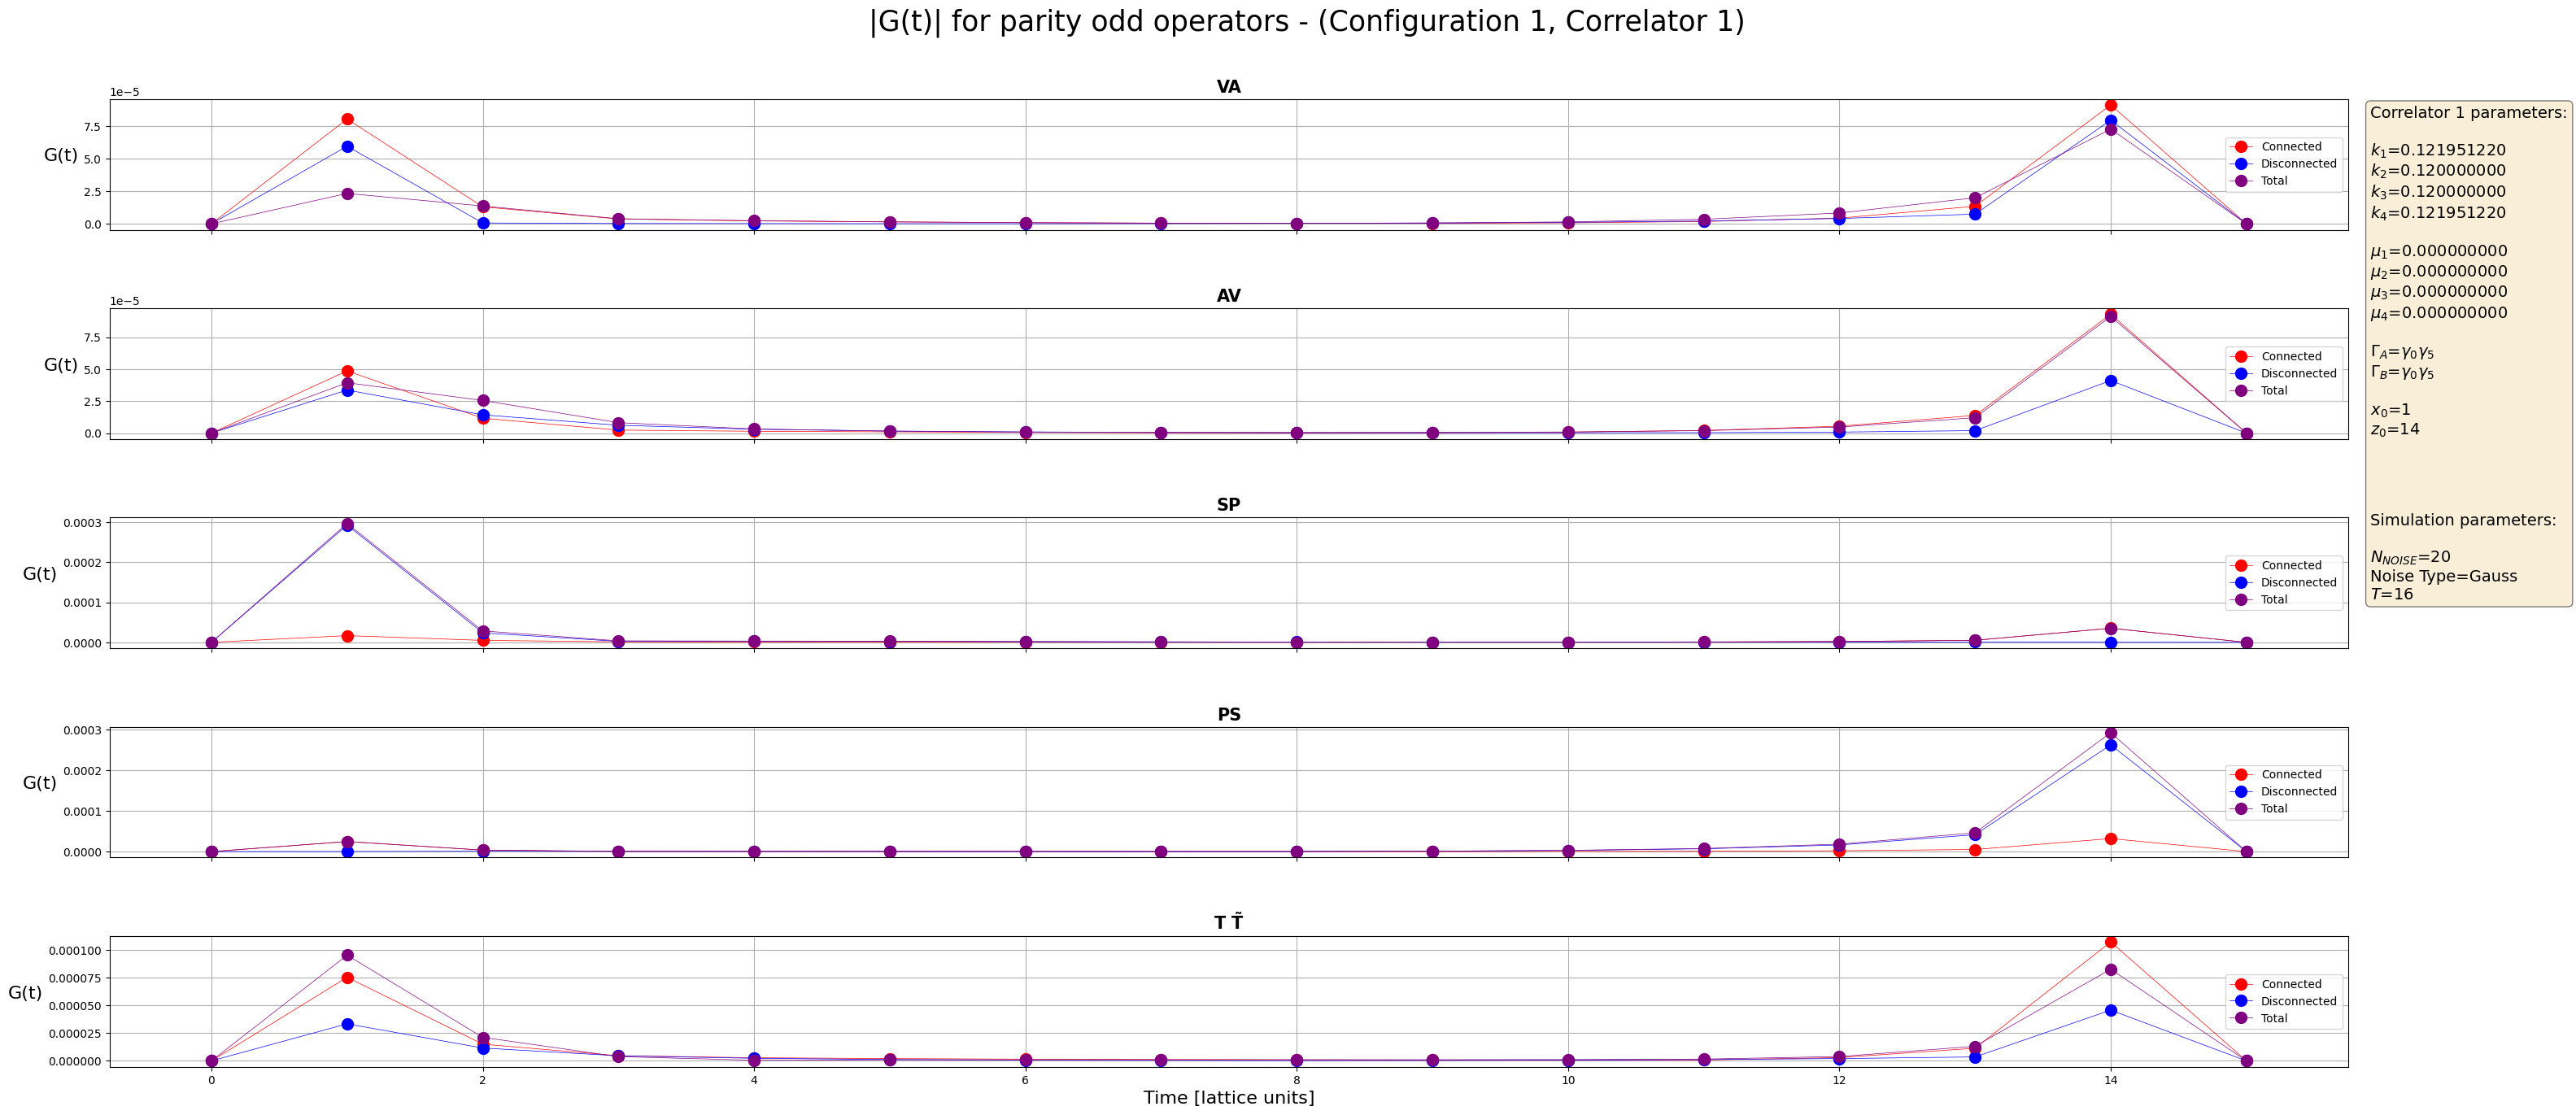

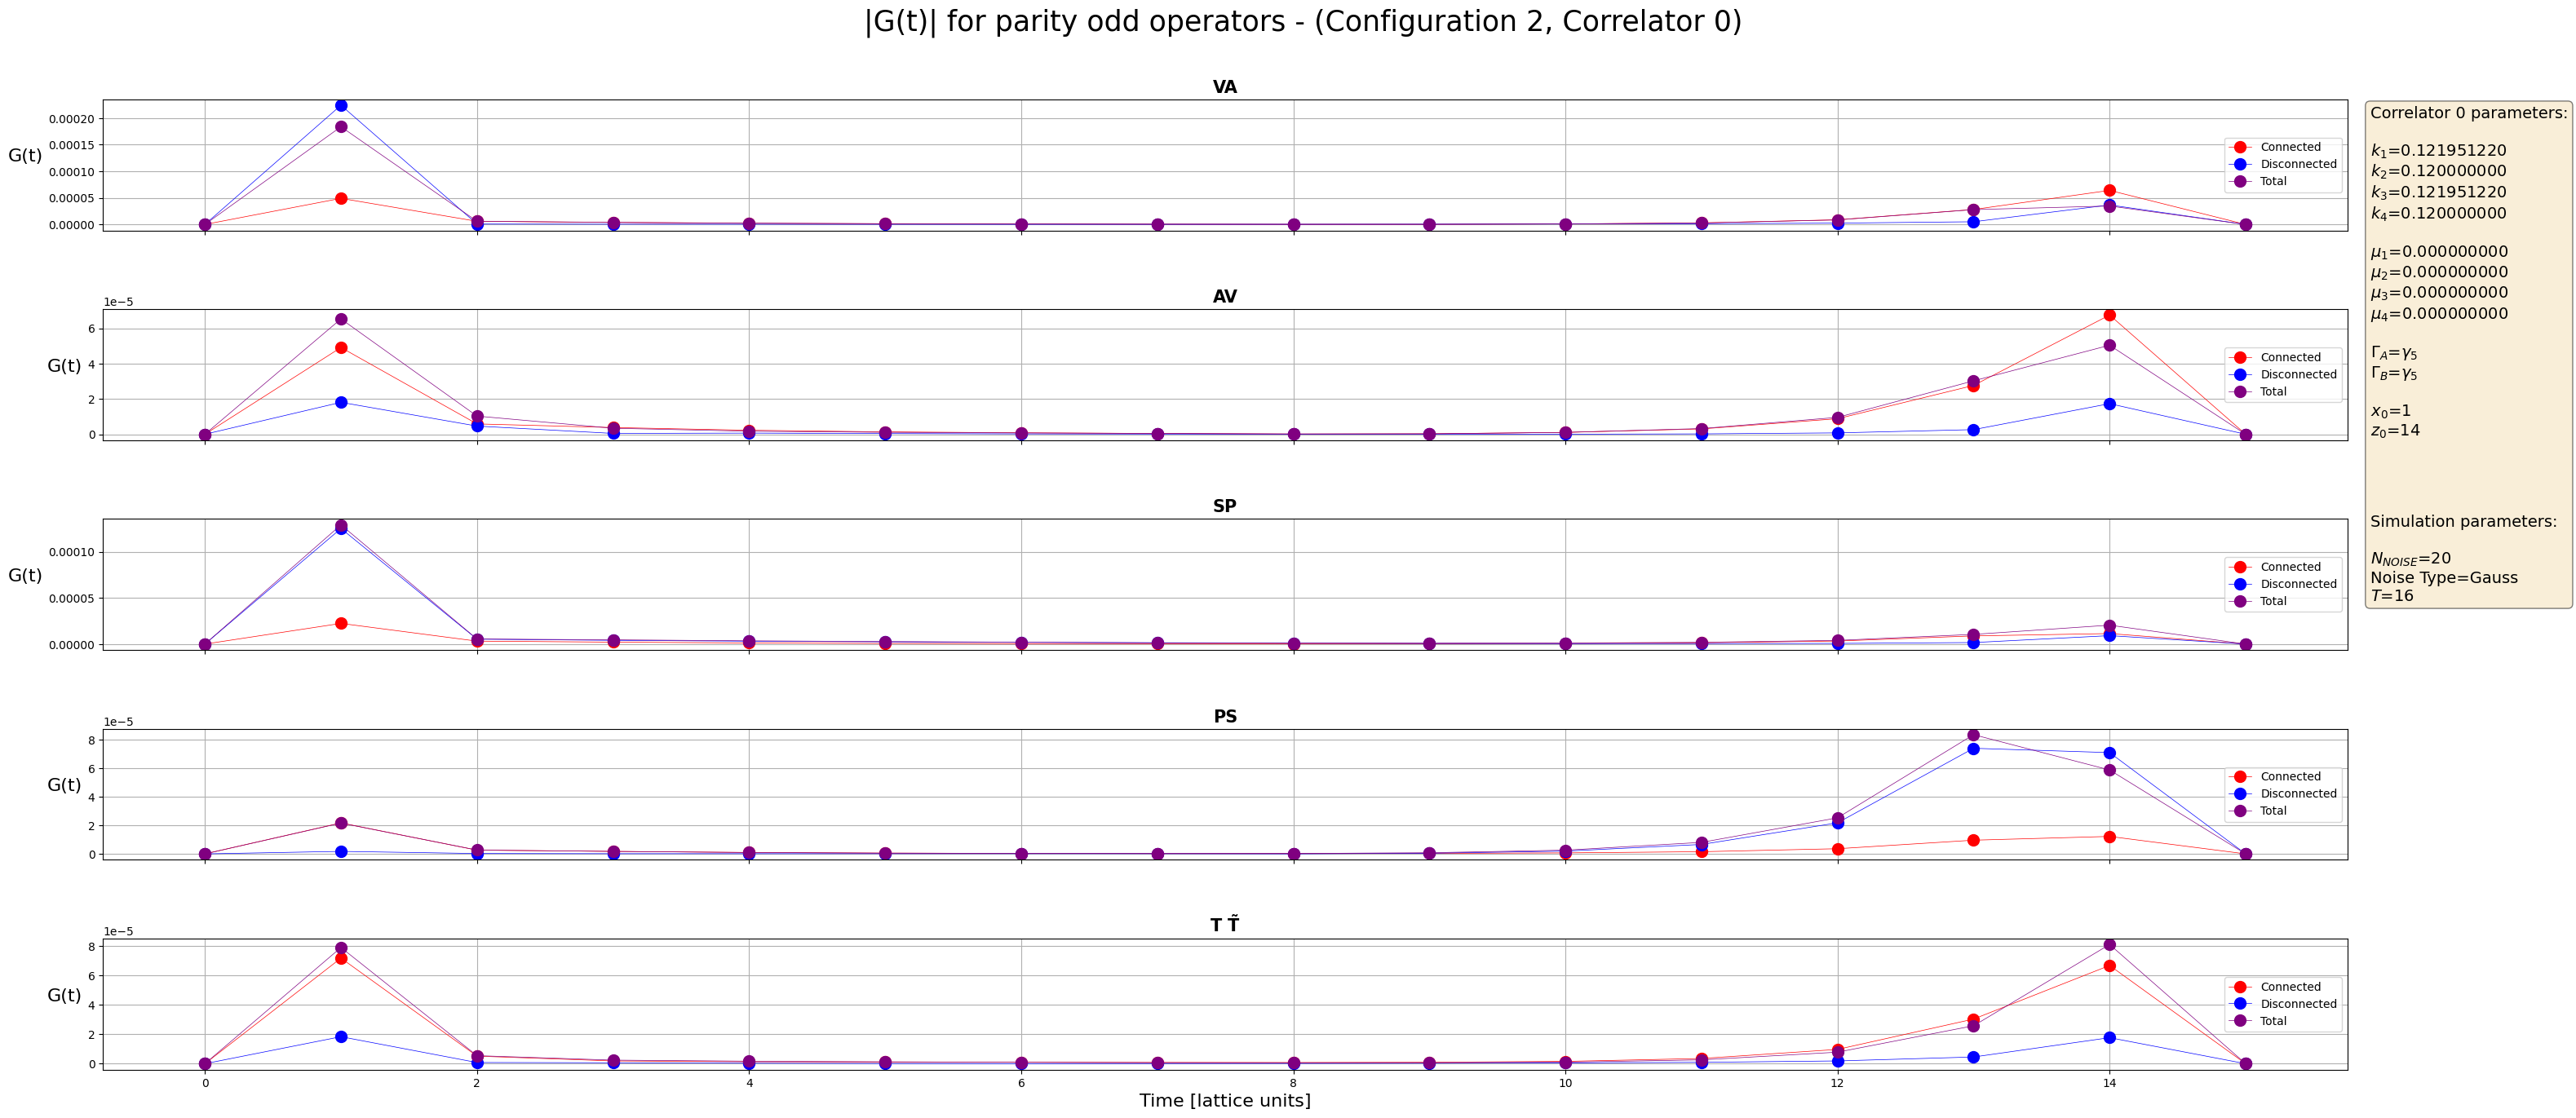

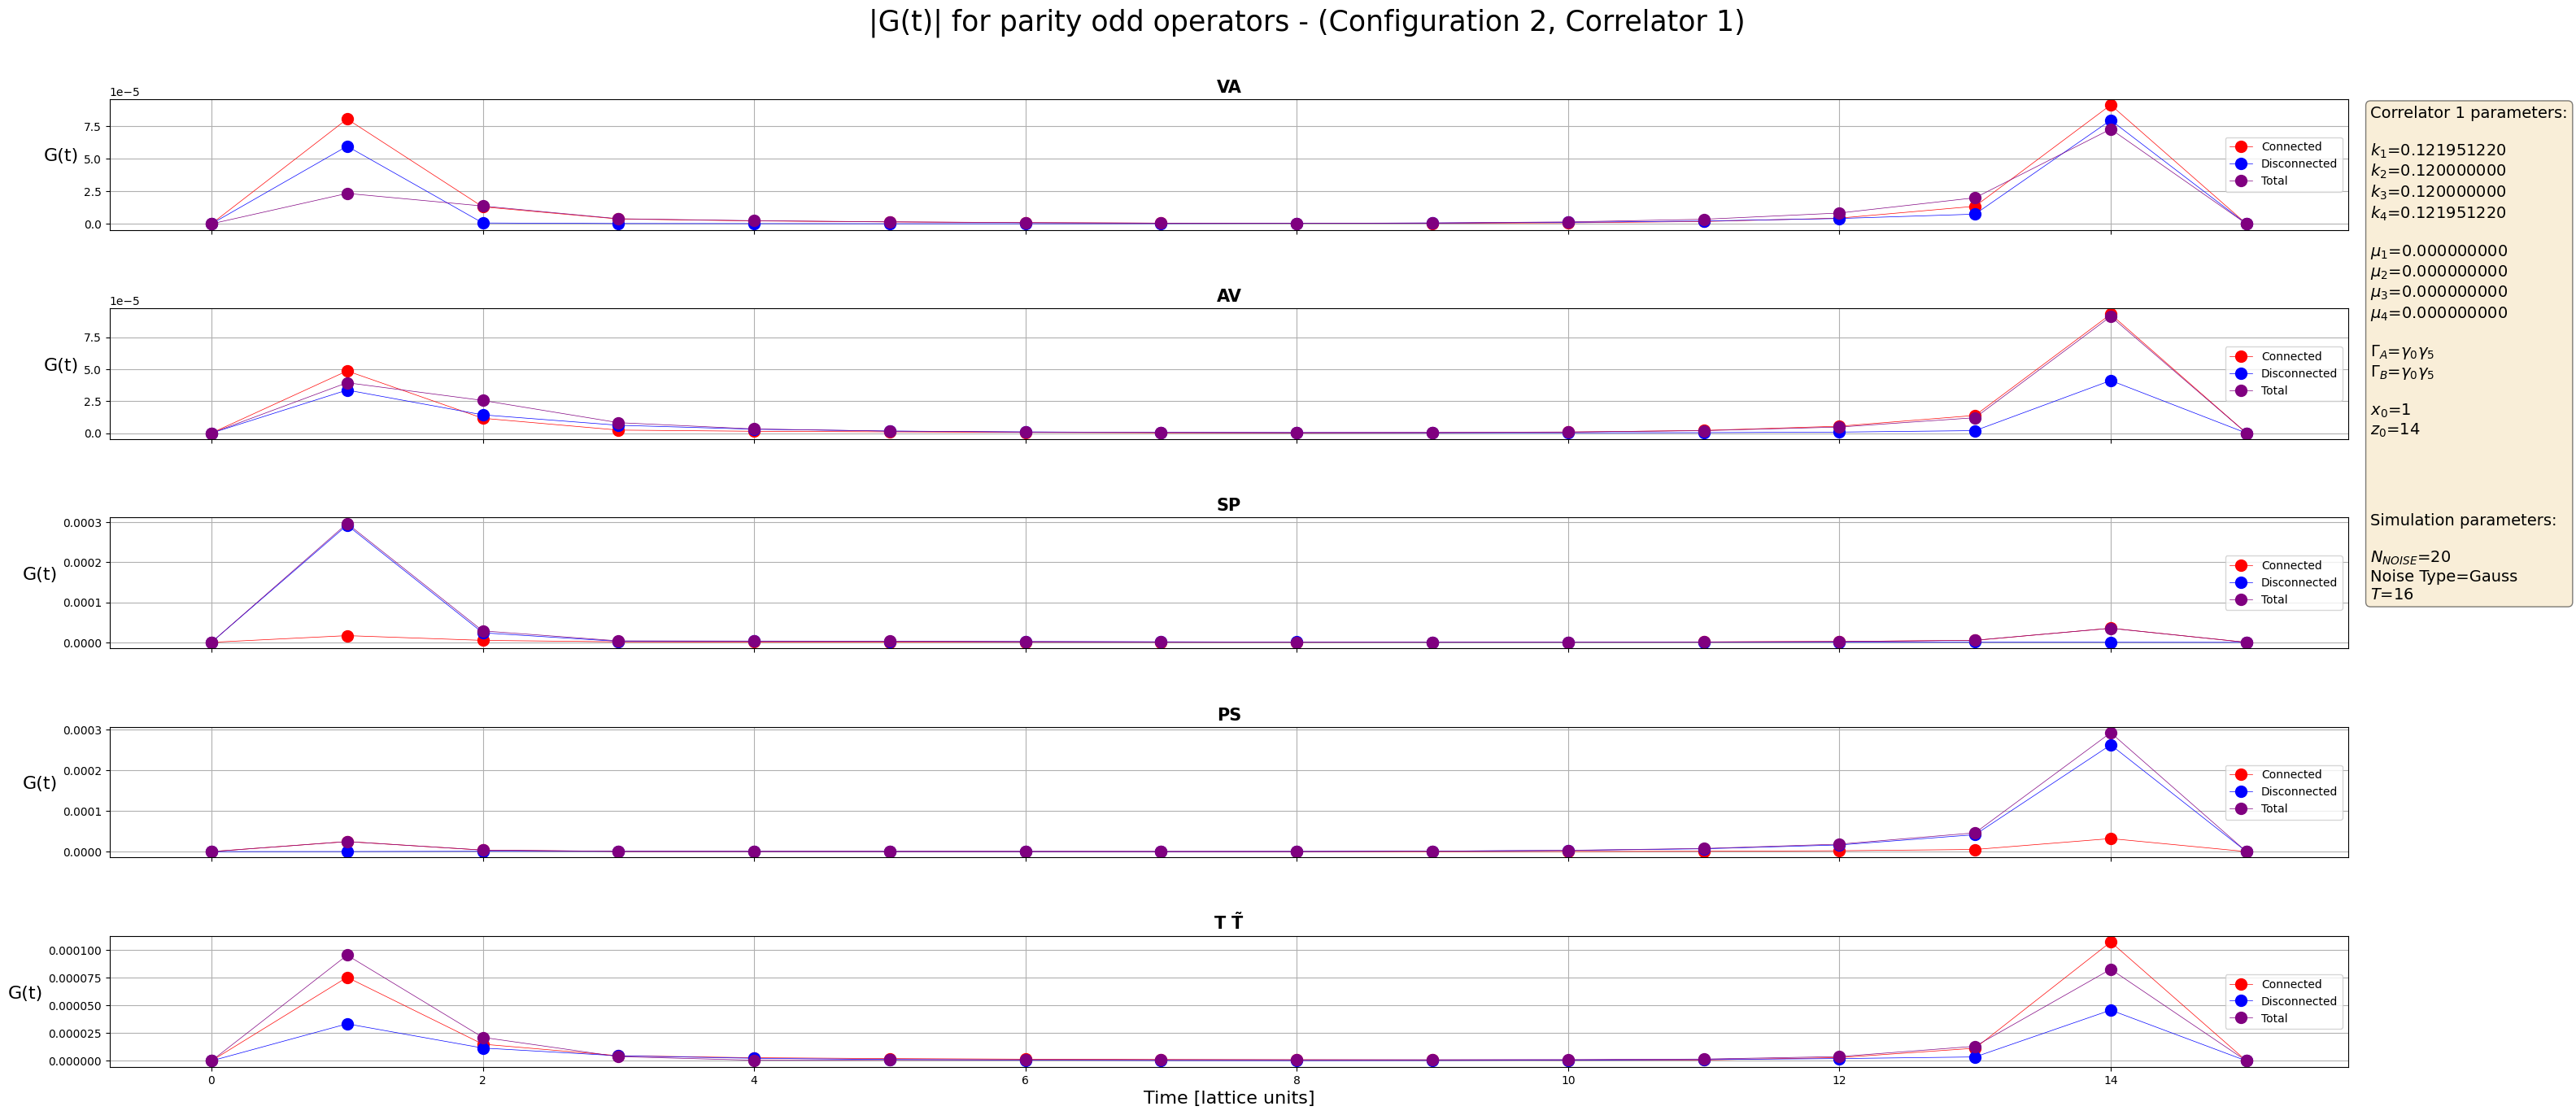

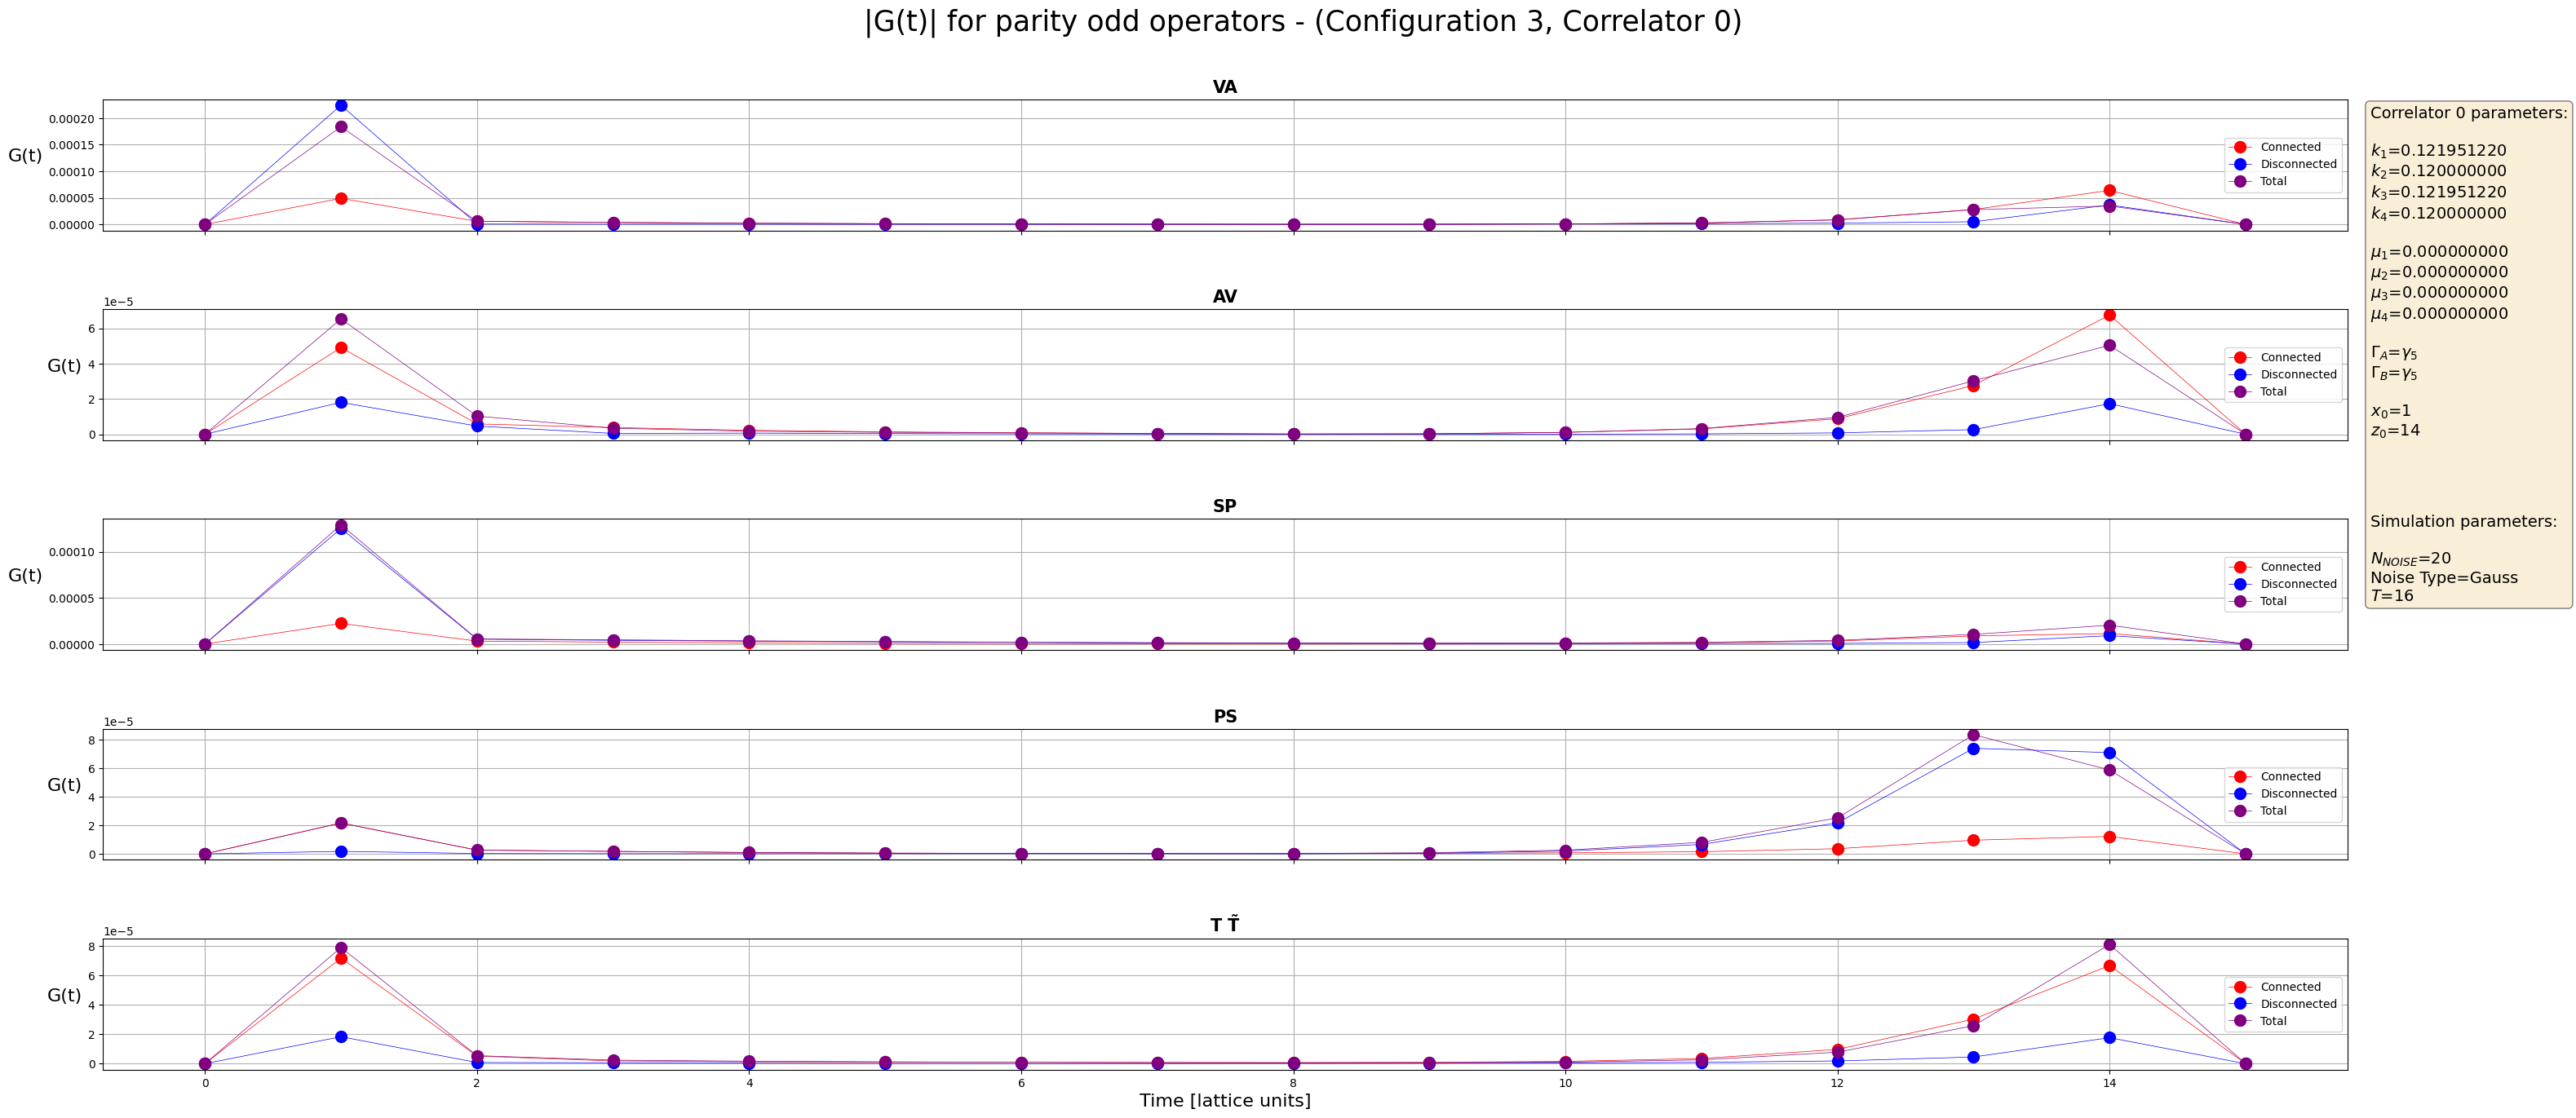

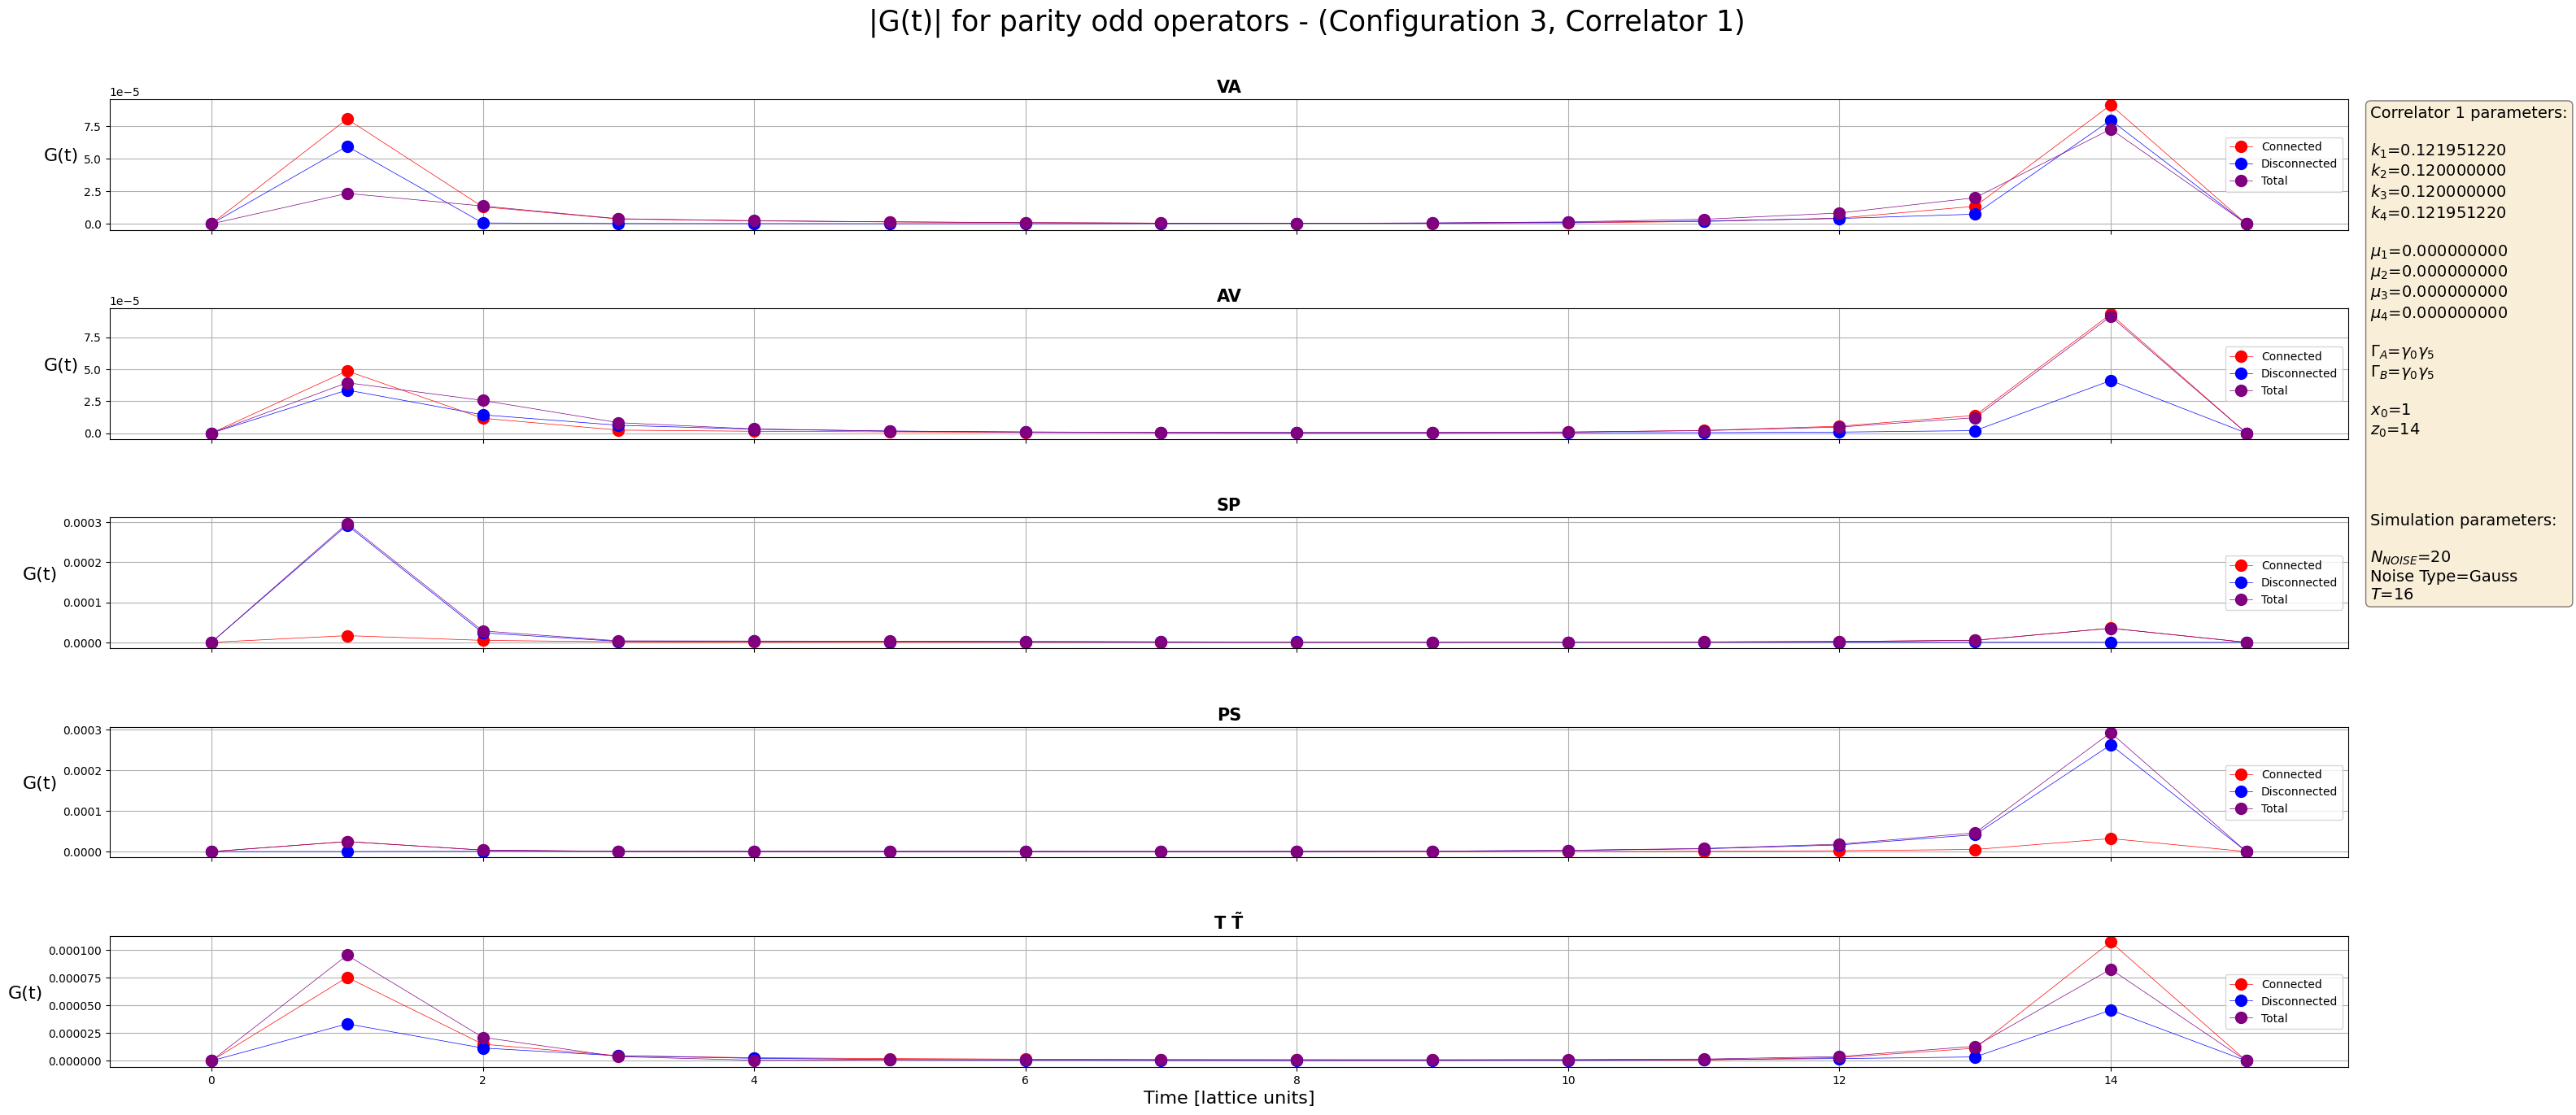

In [18]:
conf_list = list(conf_dict.keys())
#corr_list = range(ncorr)




for confNumb in conf_list:
    for corrNumb in range(ncorr):
        #plotCorr(confNumb,corrNumb,name,save=True,show=True)
        plotCorr(confNumb,corrNumb,name,save=False,show=True)

## Jacknife analysis

In [51]:
conf_dict.keys()
np.shape(conf_dict['1'])

dict_keys(['1', '2', '3'])

(2, 2, 5, 16, 20, 20)

In [52]:
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_names
conf_list = [int(conf) for conf in conf_names ]
conf_list
#nconf = int(conf_names[-1-check_gauge_inv]) - int(conf_names[0]) +1
nconf = len(conf_list)
nconf

['1', '2', '3']

[1, 2, 3]

3

In [53]:
all_correlators = np.empty(shape=(nconf,2,ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #2 is for connected and disconnected

for iconf,nameconf in enumerate(conf_names):
    all_correlators[iconf] = conf_dict[nameconf]

In [54]:
(all_correlators[0,:,:,:,:,:,:] == conf_dict[conf_names[0]] ).all()

True

In [82]:
lll = np.array((),dtype=complex)
lll

array([], dtype=complex128)

In [55]:
np.shape(all_correlators)
#nconf parts ncorr nop tvals nnoise nnoise

(3, 2, 2, 5, 16, 20, 20)

In [56]:
all_correlators_navg = all_correlators.mean(axis=-1).mean(axis=-1)
np.shape(all_correlators_navg)

(3, 2, 2, 5, 16)

In [59]:
ok = np.delete(all_correlators_navg,1,axis=0)
np.shape(ok)

ok2 = all_correlators_navg[1,:,:,:,:] 
np.shape(ok2)
(ok[:,:,:,:,:]==all_correlators_navg[0,:,:,:,:] ).all()

(2, 2, 2, 5, 16)

(2, 2, 5, 16)

False

In [67]:
#creation of jack replicates (the jackknife subsamples)

jack_replicates = np.asarray( [np.delete(all_correlators_navg,iconf,axis=0).mean(axis=0) for iconf in range(nconf)] )
np.shape(jack_replicates)
#nsubsamples nconf-1 parts corr op tvals ---> if .mean() is not called
#instead taking the mean:
#nreplicates=nconf parts corr op tvals

(3, 2, 2, 5, 16)

In [64]:
#(jack_replicates[0,1,:,:,:,:]==all_correlators_navg[2,:,:,:,:]).all() #this check works if in the above cell the mean is not take

In [68]:
jack_mean = jack_replicates.mean(axis=0)
np.shape(jack_mean)
#parts corr op tvals

(2, 2, 5, 16)

(3, 16)

<ErrorbarContainer object of 3 artists>

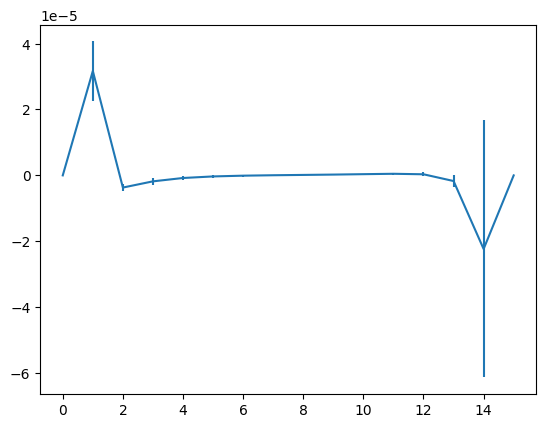

In [78]:
#plot examples

chosen_corr = jack_replicates[:,0,0,0,:].imag
np.shape(chosen_corr)

jack_mean = chosen_corr.mean(axis=0)
jack_std = np.sqrt(nconf-1) * np.std(chosen_corr,axis=0)

plt.errorbar(np.arange(tvals),jack_mean,yerr=jack_std)